In [1]:
import tensorflow as tf
import helper_functions as hf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
print(tf.__version__)
tf.config.list_physical_devices("GPU")

2022-05-20 09:10:29.726484: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


2.3.0


2022-05-20 09:10:32.661760: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-05-20 09:10:32.797017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-05-20 09:10:32.798095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-05-20 09:10:32.799149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBan

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [2]:
pathName = "data/archive/Garbage classification/Garbage classification"
hf.walk_through_dir(pathName)

There are 6 directories and 0 images in 'data/archive/Garbage classification/Garbage classification'.
There are 0 directories and 482 images in 'data/archive/Garbage classification/Garbage classification/plastic'.
There are 0 directories and 403 images in 'data/archive/Garbage classification/Garbage classification/cardboard'.
There are 0 directories and 410 images in 'data/archive/Garbage classification/Garbage classification/metal'.
There are 0 directories and 137 images in 'data/archive/Garbage classification/Garbage classification/trash'.
There are 0 directories and 594 images in 'data/archive/Garbage classification/Garbage classification/paper'.
There are 0 directories and 501 images in 'data/archive/Garbage classification/Garbage classification/glass'.


In [3]:
#Setup data inputs

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
#train_data, test_data = tfds.load(pathName+"/plastics", split=["test", "train"])

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(pathName, validation_split=0.1, 
                                                                    subset="training", seed=42, batch_size=32, 
                                                                    image_size=(224, 224))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(pathName, validation_split=0.1, 
                                                                   subset="validation", seed=42, batch_size=32, 
                                                                   image_size=(224, 224))
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)

print(classes)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2527 files belonging to 6 classes.
Using 2275 files for training.


2022-05-20 09:10:38.783553: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 09:10:38.811615: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3597940000 Hz
2022-05-20 09:10:38.812715: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x63d0180 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-20 09:10:38.812748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-20 09:10:39.586907: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x631cca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-20 09:10:39.586931: I tensorfl

Found 2527 files belonging to 6 classes.
Using 252 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


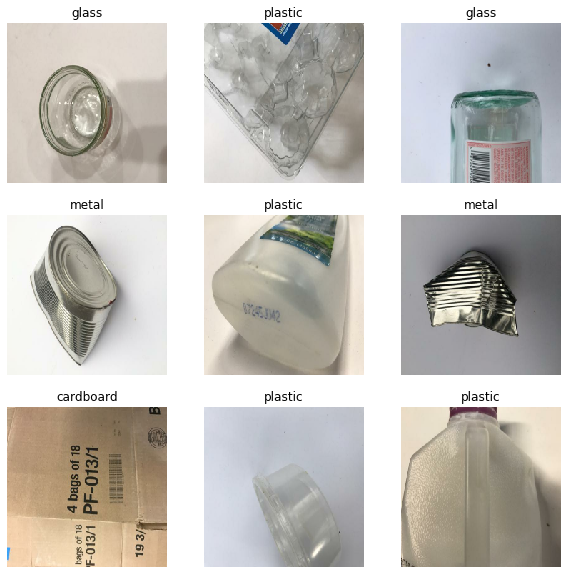

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")


In [25]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#base_model = tf.keras.models.load_model('/home/westonrobot/catkin_ws/src/test_move/src/WasteClassificationModel.h5')

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False 

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important infromation, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_dataset,
                                 epochs=5,
                                 steps_per_epoch=len(train_dataset),
                                 validation_data=test_dataset,
                                 validation_steps=int(0.25 * len(test_dataset)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model_0.save("my_h5_model")


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220520-103850


2022-05-20 10:38:50.816975: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-05-20 10:38:50.817036: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


Epoch 1/5
 1/72 [..............................] - ETA: 0s - loss: 2.4885 - accuracy: 0.0625

2022-05-20 10:38:55.432255: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-05-20 10:38:55.432373: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


 5/72 [=>............................] - ETA: 18s - loss: 2.2053 - accuracy: 0.1813

2022-05-20 10:38:56.571746: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-05-20 10:38:56.579256: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: transfer_learning/10_percent_feature_extraction/20220520-103850/train/plugins/profile/2022_05_20_10_38_56
2022-05-20 10:38:56.580814: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to transfer_learning/10_percent_feature_extraction/20220520-103850/train/plugins/profile/2022_05_20_10_38_56/westonrobot-All-Series.trace.json.gz
2022-05-20 10:38:56.604212: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: transfer_learning/10_percent_feature_extraction/20220520-103850/train/plugins/profile/2022_05_20_10_38_56
2022-05-20 10:38:56.608575: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.g

72/72 [==============================] - 7s 100ms/step - loss: 1.0634 - accuracy: 0.6475 - val_loss: 0.5537 - val_accuracy: 0.8281
Epoch 2/5
72/72 [==============================] - 5s 67ms/step - loss: 0.5472 - accuracy: 0.8334 - val_loss: 0.4871 - val_accuracy: 0.8281
Epoch 3/5
72/72 [==============================] - 5s 67ms/step - loss: 0.4479 - accuracy: 0.8607 - val_loss: 0.4812 - val_accuracy: 0.8125
Epoch 4/5
72/72 [==============================] - 5s 68ms/step - loss: 0.3903 - accuracy: 0.8853 - val_loss: 0.3412 - val_accuracy: 0.8750
Epoch 5/5
72/72 [==============================] - 5s 68ms/step - loss: 0.3424 - accuracy: 0.9046 - val_loss: 0.3101 - val_accuracy: 0.9219
INFO:tensorflow:Assets written to: my_h5_model/assets


In [27]:
# It can be used to reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("my_h5_model")

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.evaluate(test_dataset)

8/8 [==============================] - 0s 40ms/step - loss: 0.3647 - accuracy: 0.1468


[0.3647143542766571, 0.1468254029750824]

In [28]:
reconstructed_model.fit(train_dataset, epochs = 5, validation_data = test_dataset,verbose=1)

reconstructed_model.save("my_h5_model")

Epoch 1/5
72/72 [==============================] - 16s 216ms/step - loss: 0.5737 - accuracy: 0.1582 - val_loss: 1.2656 - val_accuracy: 0.0913
Epoch 2/5
72/72 [==============================] - 16s 219ms/step - loss: 0.1968 - accuracy: 0.1648 - val_loss: 0.6458 - val_accuracy: 0.2024
Epoch 3/5
72/72 [==============================] - 16s 220ms/step - loss: 0.1794 - accuracy: 0.1640 - val_loss: 0.4313 - val_accuracy: 0.1151
Epoch 4/5
72/72 [==============================] - 16s 222ms/step - loss: 0.1713 - accuracy: 0.1635 - val_loss: 0.4737 - val_accuracy: 0.1270
Epoch 5/5
72/72 [==============================] - 16s 218ms/step - loss: 0.0910 - accuracy: 0.1631 - val_loss: 0.3010 - val_accuracy: 0.1230


[  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.] 
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Prediction:  plastic 99.99111890792847%


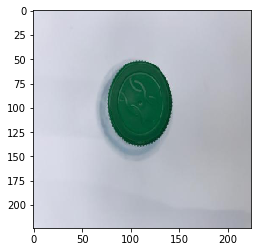

In [29]:
import matplotlib.pyplot as plt
import numpy as np
path = "/home/westonrobot/catkin_ws/src/test_move/src/images/copy/plastic19.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = reconstructed_model.predict(img_array)

plt.imshow(img)
print(np.around(predictions[0]*100,decimals =1), "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

In [29]:
# Load protobuf as graph, given filepath
def load_pb(path_to_pb):
    with tf.io.gfile.GFile(path_to_pb, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph


tf_graph = load_pb('ssd_mobilenet_v2_taco_2018_03_29.pb')
variables = [op.name for op in tf_graph.get_operations() if op.type == "Const"]
print(variables)

['Const', 'Preprocessor/map/strided_slice/stack', 'Preprocessor/map/strided_slice/stack_1', 'Preprocessor/map/strided_slice/stack_2', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2', 'Preprocessor/map/TensorArrayUnstack/range/start', 'Preprocessor/map/TensorArrayUnstack/range/delta', 'Preprocessor/map/Const', 'Preprocessor/map/while/iteration_counter', 'Preprocessor/map/while/add/y', 'Preprocessor/map/while/ResizeImage/stack', 'Preprocessor/map/while/ResizeImage/resize/ExpandDims/dim', 'Preprocessor/map/while/ResizeImage/stack_1', 'Preprocessor/map/while/add_1/y', 'Preprocessor/map/TensorArrayStack/range/start', 'Preprocessor/map/TensorArrayStack/range/delta', 'Preprocessor/map/TensorArrayStack_1/range/start', 'Preprocessor/map/TensorArrayStack_1/range/delta', 'Preprocessor/mul/x', 'Preprocessor/sub/y', 'FeatureExtractor/MobilenetV2/Conv/weights', 'Feature

In [ ]:
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    print("-" * 50)
    print("Frozen model layers: ")
    layers = [op.name for op in import_graph.get_operations()]
    if print_graph == True:
        for layer in layers:
            print(layer)
    print("-" * 50)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))

# Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("ssd_mobilenet_v2_taco_2018_03_29.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["x:0"],
                                outputs=["Identity:0"],
                                print_graph=True)